In [1]:
import json
import numpy as np

json_dir='/Users/tommy/workspace/data/psout/ezio_checker_new.json'

class confmat_stat(object):
    def __init__(self,path):
        try:
            with open(path, 'rb')  as f:
                self.data = json.load(f)
                #print "read data complete"
                self.enable = True
        except Exception as e:
                print e
        self.order = self.data.keys()
        self.class_good = []
        self.class_bad = []
        
    def category(self):
        for orderId in self.order:
            viewList = self.data[orderId].keys()
            for viewId in viewList:
                one_view = self.data[orderId][viewId]
                if (one_view['label'] == 'good'):
                    self.class_good.append((one_view,(orderId,viewId)))
                elif (one_view['label'] == 'bad'):
                    self.class_bad.append((one_view,(orderId,viewId)))
        print('class good total: ',len(self.class_good))
        print('class bad total: ',len(self.class_bad))
        
    def flatten_data(self,one_view):
        #print(one_view.keys())
        recall_vec = np.array(one_view['recall']).flatten()
        iou_vec = np.array(one_view['iou']).flatten()
        confmat = np.array(one_view['matrix']).flatten()
        confmat = confmat.astype(np.double)
        confmat /= (224.0*224.0)
        prec_vec = np.array(one_view['precision']).flatten()
        
        feature_vec = np.array([])
        feature_vec = np.hstack((feature_vec,confmat))
        feature_vec = np.hstack((feature_vec,prec_vec))
        feature_vec = np.hstack((feature_vec,recall_vec))
        feature_vec = np.hstack((feature_vec,iou_vec))
        
        return feature_vec
    
    def concat(self):
        data = np.array([])
        label = []
        id_list = []
        dim = 0
        for class_good_, id_tuple in self.class_good:
            data = np.hstack((data,self.flatten_data(class_good_)))
            dim = len(self.flatten_data(class_good_))
            label.append(1) #good first, is 1
            id_list.append(id_tuple)
        for class_bad_, id_tuple in self.class_bad:
            data = np.hstack((data,self.flatten_data(class_bad_)))
            label.append(2) #bad second, is 2
            id_list.append(id_tuple)
        #print(dim)
        data = np.reshape(data, (-1,dim))
        label = np.array(label)
        self.id_list = id_list
        return data,label,id_list
    
    def get_label(self,id_tuple):
        orderId,viewId = id_tuple
        one_view = self.data[orderId][viewId]
        return one_view['label']
    
stat = confmat_stat(json_dir)
stat.category()
data,label,id_list = stat.concat()
print(data.shape,label.shape,len(id_list))
print(stat.get_label(id_list[0]))
print(data[0])

('class good total: ', 304)
('class bad total: ', 45)
((349, 18), (349,), 349)
good
[5.42809311e-01 1.59438776e-03 1.43494898e-03 2.10459184e-02
 3.84785555e-01 3.08912628e-03 1.79368622e-04 5.58035714e-04
 4.45033482e-02 9.62368821e-01 9.94437291e-01 9.07723577e-01
 9.94450124e-01 9.40978653e-01 9.83700441e-01 9.57227709e-01
 9.36051585e-01 8.94273128e-01]


[0.57344527 0.15551546 0.12146731]


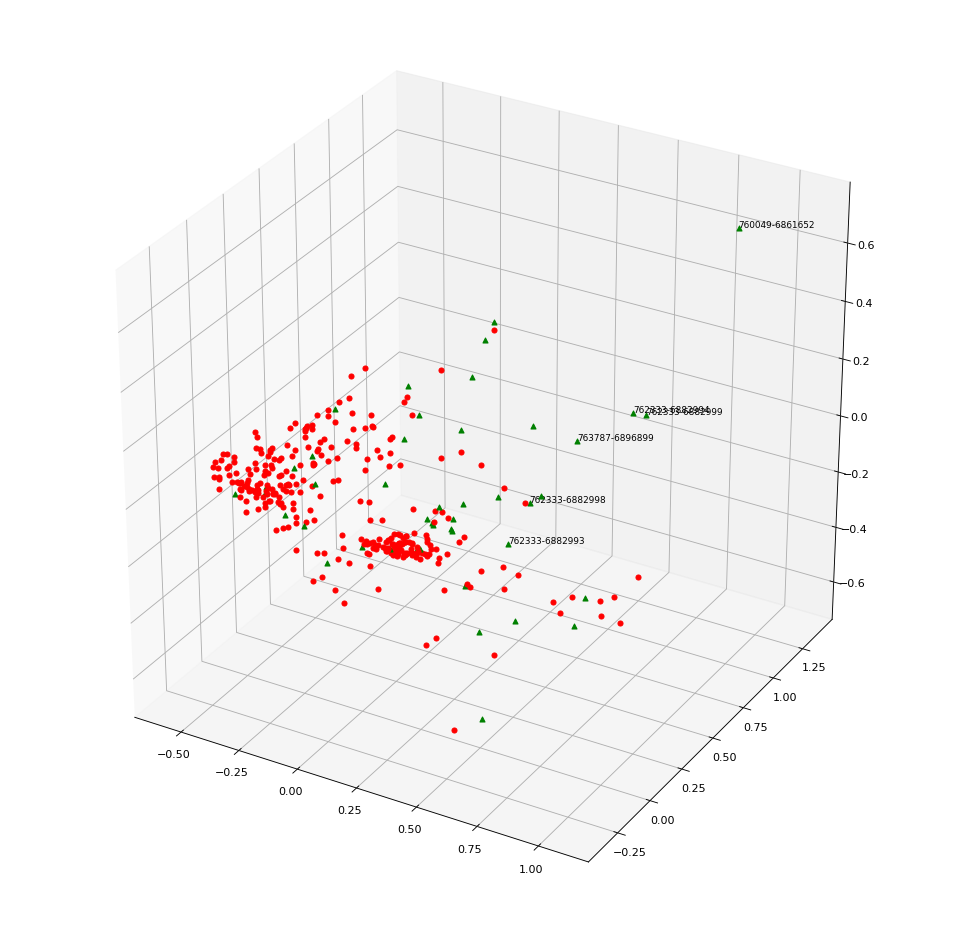

In [2]:
#lets do some data visualization
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(data)
X = pca.transform(data)
print(pca.explained_variance_ratio_)  

x = X[:,0]
y = X[:,1]
z = X[:,2]

colors = ['r','g']
shape = ['o','^']
#fig = plt.figure(figsize=(8,8))
#plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))
fig = plt.figure(figsize=(15, 15), dpi= 80)
ax = fig.add_subplot(111, projection='3d')
for i in range(X.shape[0]):
    ax.scatter(x[i], y[i], z[i], c=colors[label[i]-1], marker=shape[label[i]-1])
    if(label[i] == 2 and x[i] > -0.25 and y[i]>0.5):
        txt = str(id_list[i][0])+"-"+str(id_list[i][1])
        ax.text(x[i], y[i], z[i], txt, size=8, zorder=1,color='k') 
plt.show()

((349, 18), (349,))
(349,)
('test acc', 0.9083094555873925)
('coef', array([[  -4.8669587 ,   22.01736466,   31.95244196,  111.19259301,
          -4.3048504 ,   98.33026062,   91.93905363,   14.00186423,
          -8.21082842,    8.89334707, -232.0977239 ,    2.47145821,
         -10.0115547 , -171.32405499,    0.23881896,    8.90953934,
         214.03106993,   -3.43050047]]))
('interc', array([181.14075421]))
('scaling', array([[  -2.23715144,   10.1205254 ,   14.68729366,   51.1109063 ,
          -1.97877214,   45.19859283,   42.26080378,    6.4361119 ,
          -3.77419818,    4.08792543, -106.68628815,    1.13603313,
          -4.60192195,  -78.75099846,    0.10977578,    4.09536839,
          98.38175065,   -1.57686752]]))


/Users/tommy/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


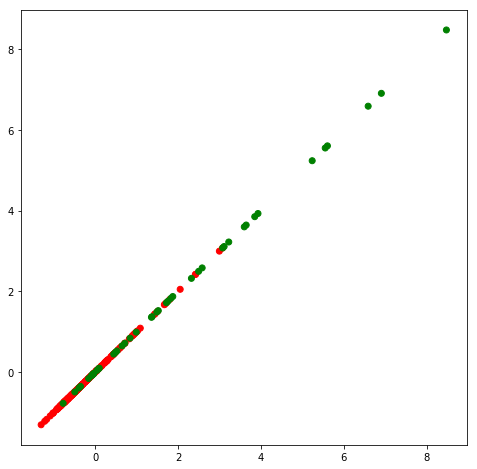

In [3]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = data
y = label

print(X.shape, y.shape)
clf = LinearDiscriminantAnalysis(store_covariance=False,n_components=1)
clf.fit(X, y)

transf = clf.transform(X)[:,0]

colors = ['red','green']
fig = plt.figure(figsize=(8,8))
print(transf.shape)
plt.scatter(transf, transf, c=label, cmap=matplotlib.colors.ListedColormap(colors))

print("test acc",clf.score(X,y))

print("coef",clf.coef_)
print("interc",clf.intercept_)
print("scaling",clf.scalings_.T)

scaling = clf.scalings_.T
coef = np.array(clf.coef_)
inter = clf.intercept_


for idx,test_data in enumerate(data):
    test_data = np.asmatrix(test_data)

    inference = np.dot(test_data,coef.T) + inter
    inference_prob = np.reciprocal(np.exp(-inference) + 1)
    
    raw_prediction = clf.predict(test_data)
    #print(inference_prob, raw_prediction)
    
    if(raw_prediction == 2):
        prediction = 'bad'
    elif (raw_prediction == 1):
        prediction = 'good'
    ground_truth = stat.get_label(id_list[idx])
    if(prediction != ground_truth):
        pass
        #print("class pred",prediction,"ground truth",ground_truth)
        
        #print(clf.predict_proba(test_data))
        
        #print("ID",id_list[idx])
        
    #print("transform",clf.decision_function(test_data))
#print(clf.covariance_)
#print(clf.explained_variance_ratio_)


In [45]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)
print(qda.score(X,y))

0.8549905838041432


/Users/tommy/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [53]:
from sklearn.svm import SVC
clf = SVC(gamma=3, C=2)
clf.fit(X, y)
print(clf.score(X,y))

0.8813559322033898
